# Loading Data

In [1]:
1

Intitializing Scala interpreter ...

Spark Web UI available at http://192.168.2.10:4040
SparkContext available as 'sc' (version = 3.0.0, master = local[*], app id = local-1612747015560)
SparkSession available as 'spark'


res0: Int = 1


In [2]:
%%python
import databricks.koalas as ks
import tempfile
from matplotlib import pyplot as plt
from IPython.display import Image
ks.set_option("plotting.max_rows", 1000000)

In [3]:
val housing = spark
    .read.format("csv").option("header","true").option("inferSchema","true").load("housing.csv")
    .select("housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value")
    .where($"total_bedrooms".isNotNull)
housing.createOrReplaceTempView("housing")
housing.show(5)

+------------------+-----------+--------------+----------+----------+-------------+------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+------------------+-----------+--------------+----------+----------+-------------+------------------+
|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|
|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|
|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|
|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|
|              52.0|     1627.0|         280.0|     565.0|     259.0|       3.8462|          342200.0|
+------------------+-----------+--------------+----------+----------+-------------+------------------+
only showing top 5 rows



housing: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [housing_median_age: double, total_rooms: double ... 5 more fields]


# Stratified Sampling

In [4]:
import org.apache.spark.ml.feature.Bucketizer

val bucketizer = new Bucketizer()
  .setInputCol("median_income")
  .setOutputCol("income_cat")
  .setSplits(Array(0,1.5,3.0,4.5,6,Double.PositiveInfinity))
val tmp = bucketizer.transform(housing)
val tmp_test = tmp.stat.sampleBy("income_cat", Map(0 -> 0.2, 1->0.2, 2->0.2, 3->0.2, 4->0.2, 5->0.2), 47)
val tmp_training = tmp.except(tmp_test)
val test = tmp_test.drop("income_cat")
val training =  tmp_training.drop("income_cat")

training.createOrReplaceTempView("training")
training.show(5)

+------------------+-----------+--------------+----------+----------+-------------+------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+------------------+-----------+--------------+----------+----------+-------------+------------------+
|              52.0|     2491.0|         474.0|    1098.0|     468.0|        3.075|          213500.0|
|              28.0|     5022.0|        1750.0|    2558.0|    1661.0|       2.4234|          218500.0|
|              52.0|     3529.0|         574.0|    1177.0|     555.0|       5.1773|          389500.0|
|              52.0|      589.0|         132.0|     288.0|     131.0|       3.5156|          200000.0|
|              29.0|     4169.0|        1047.0|    2024.0|     962.0|       2.8125|          157400.0|
+------------------+-----------+--------------+----------+----------+-------------+------------------+
only showing top 5 rows



import org.apache.spark.ml.feature.Bucketizer
bucketizer: org.apache.spark.ml.feature.Bucketizer = Bucketizer: uid=bucketizer_bcbc4572d772
tmp: org.apache.spark.sql.DataFrame = [housing_median_age: double, total_rooms: double ... 6 more fields]
tmp_test: org.apache.spark.sql.DataFrame = [housing_median_age: double, total_rooms: double ... 6 more fields]
tmp_training: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [housing_median_age: double, total_rooms: double ... 6 more fields]
test: org.apache.spark.sql.DataFrame = [housing_median_age: double, total_rooms: double ... 5 more fields]
training: org.apache.spark.sql.DataFrame = [housing_median_age: double, total_rooms: double ... 5 more fields]


# Correlation

In [5]:
%%python
training = spark.table("training").to_koalas()
corr_matrix = training.corr()
print(corr_matrix)

                    housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value
housing_median_age            1.000000    -0.364658       -0.325742   -0.296989   -0.308698      -0.113291            0.110819
total_rooms                  -0.364658     1.000000        0.930926    0.853653    0.918673       0.198311            0.133444
total_bedrooms               -0.325742     0.930926        1.000000    0.873937    0.978587      -0.007011            0.049721
population                   -0.296989     0.853653        0.873937    1.000000    0.905370       0.006607           -0.024953
households                   -0.308698     0.918673        0.978587    0.905370    1.000000       0.015460            0.064887
median_income                -0.113291     0.198311       -0.007011    0.006607    0.015460       1.000000            0.687434
median_house_value            0.110819     0.133444        0.049721   -0.024953    0.064887       0.687434     

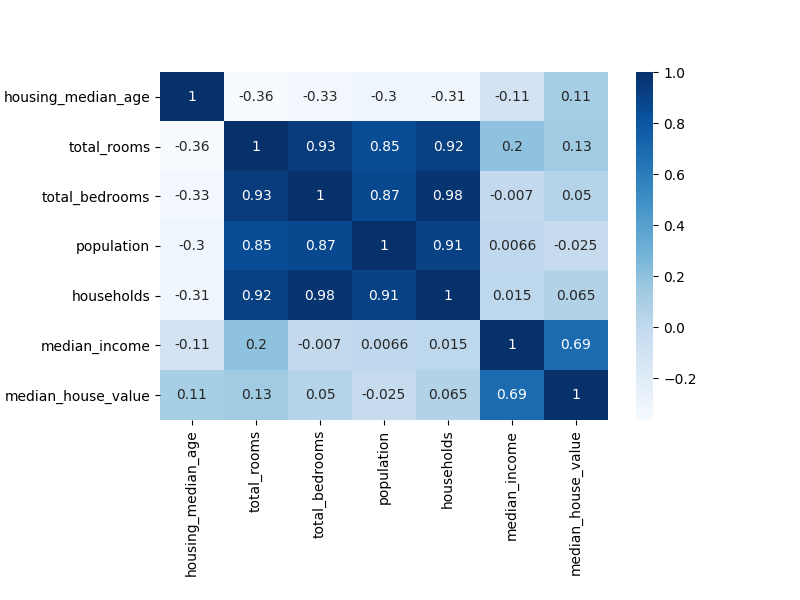

In [6]:
%%python
import seaborn as sns

columns = ["housing_median_age", "total_rooms", "total_bedrooms", "population", 
           "households", "median_income", "median_house_value"]

plt.figure(figsize=(8, 6))
plt.gcf().subplots_adjust(bottom=0.30)
plt.gcf().subplots_adjust(left=0.20)

sns.heatmap(corr_matrix.to_numpy(), cmap='Blues', annot = True, square = False,
            xticklabels=columns,yticklabels=columns)

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

In [7]:
%%python
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687434
total_rooms           0.133444
housing_median_age    0.110819
households            0.064887
total_bedrooms        0.049721
population           -0.024953
Name: median_house_value, dtype: float64


In [8]:
val training2 = training
    .withColumn("rooms_per_house_hold", $"total_rooms"/$"households")
    
training2.createOrReplaceTempView("training2")
training2.show(10)

+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|rooms_per_house_hold|
+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|              52.0|     2491.0|         474.0|    1098.0|     468.0|        3.075|          213500.0|   5.322649572649572|
|              28.0|     5022.0|        1750.0|    2558.0|    1661.0|       2.4234|          218500.0|  3.0234798314268514|
|              52.0|     3529.0|         574.0|    1177.0|     555.0|       5.1773|          389500.0|   6.358558558558559|
|              52.0|      589.0|         132.0|     288.0|     131.0|       3.5156|          200000.0|  4.4961832061068705|
|              29.0|     4169.0|        1047.0|    2024.0|     962.0|       2.8125|          157400.0|   4.333679833679834|
|       

training2: org.apache.spark.sql.DataFrame = [housing_median_age: double, total_rooms: double ... 6 more fields]


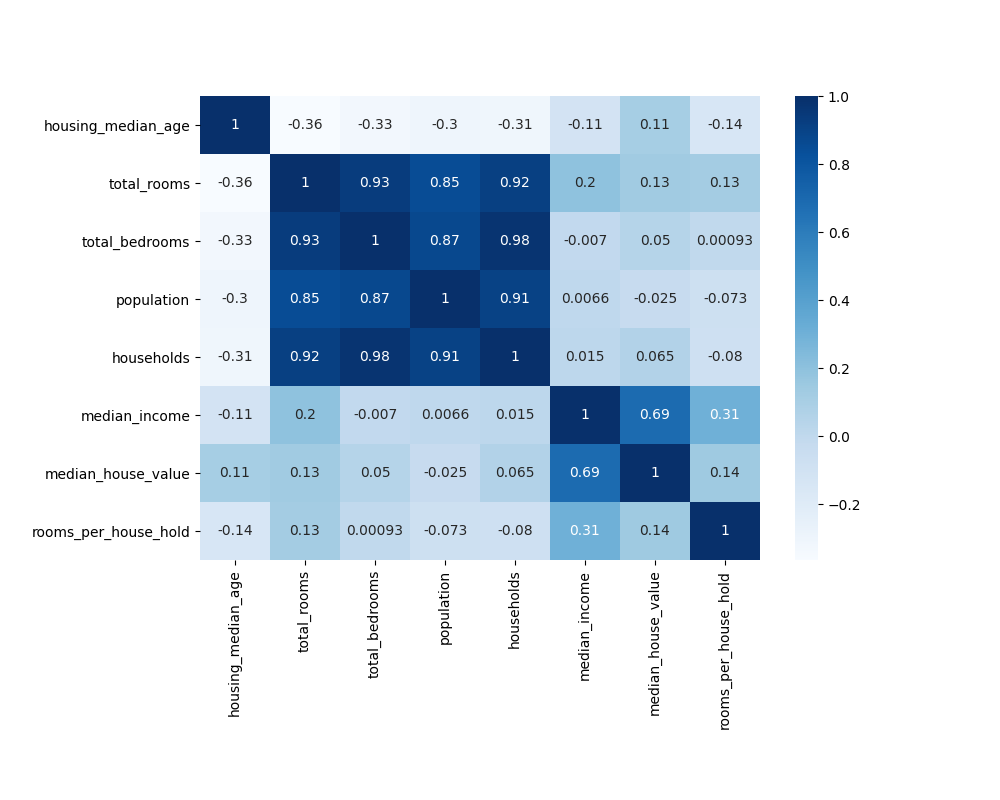

In [13]:
%%python
columns = ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
           "median_income", "median_house_value", 
           "rooms_per_house_hold"]
training2 = spark.table("training2").to_koalas()
corr_matrix2 = training2.corr()


plt.figure(figsize=(10, 8))
plt.gcf().subplots_adjust(bottom=0.30)
plt.gcf().subplots_adjust(left=0.20)

sns.heatmap(corr_matrix2.to_numpy(), cmap='Blues', annot = True, square = False,
            xticklabels=columns,yticklabels=columns)

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

In [10]:
%%python
print(corr_matrix2["median_house_value"].sort_values(ascending=False))

median_house_value      1.000000
median_income           0.687434
rooms_per_house_hold    0.144969
total_rooms             0.133444
housing_median_age      0.110819
households              0.064887
total_bedrooms          0.049721
population             -0.024953
Name: median_house_value, dtype: float64


In [11]:
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.linalg.Vectors
import org.apache.spark.ml.linalg.{Matrix, Vectors}
import org.apache.spark.ml.stat.Correlation
import org.apache.spark.sql.Row
// import org.apache.spark.sql.Dataset


val assembler = new VectorAssembler()
  .setInputCols(Array("housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"))
  .setOutputCol("features")

val training3 = assembler.transform(training)

val Row(coeff: Matrix)  = Correlation.corr(training3, "features").head
println(s"Pearson correlation matrix:\n $coeff")

Pearson correlation matrix:
 1.0                   -0.364657872384687   -0.32574222311239703   ... (7 total)
-0.364657872384687    1.0                  0.9309262173226253     ...
-0.32574222311239703  0.9309262173226253   1.0                    ...
-0.2969892893772599   0.8536528769344078   0.8739373135358511     ...
-0.30869756575257107  0.9186726810561211   0.978587133785426      ...
-0.11329130197317498  0.19831115386447534  -0.007011483039509093  ...
0.11081868330595399   0.1334439647808908   0.049721135793896365   ...


import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.linalg.Vectors
import org.apache.spark.ml.linalg.{Matrix, Vectors}
import org.apache.spark.ml.stat.Correlation
import org.apache.spark.sql.Row
assembler: org.apache.spark.ml.feature.VectorAssembler = VectorAssembler: uid=vecAssembler_2ecd7171a0a4, handleInvalid=error, numInputCols=7
training3: org.apache.spark.sql.DataFrame = [housing_median_age: double, total_rooms: double ... 6 more fields]
coeff: org.apache.spark.ml.linalg.Matrix =
1.0                   -0.364657872384687   -0.32574222311239703   ... (7 total)
-0.364657872384687    1.0                  0.9309262173226253     ...
-0.32574222311239703  0.9309262173226253   1.0                    ...
-0.2969892893772599   0.8536528769344078   0.873937313535851...


In [12]:
training3.stat.corr("median_house_value","median_income")

res5: Double = 0.6874343448220304
